## Mortage Default Prediction

In [ ]:
import ibmos2spark
# @hidden_cell
credentials = {
    'endpoint': 'https://s3.eu-geo.objectstorage.service.networklayer.com',
    'service_id': 'iam-ServiceId-ddd47da4-acfa-4590-babf-ab051b7f77b6',
    'iam_service_endpoint': 'https://iam.eu-gb.bluemix.net/oidc/token',
    'api_key': 'kCxdy2mVdTMcTotMupUlOh_cc6Wrynmh4b7kIAIZ98AU'
}

configuration_name = 'os_f99601c62bd54655b8bdd838cc2ad12e_configs'
cos = ibmos2spark.CloudObjectStorage(sc, credentials, configuration_name, 'bluemix_cos')

from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
data = spark.read\
  .format('org.apache.spark.sql.execution.datasources.csv.CSVFileFormat')\
  .option('header', 'true')\
  .option('inferSchema', 'true')\
  .load(cos.url('Mortgage_Training Data.csv', 'pyrtraining-donotdelete-pr-8zy0j2en6j4jea'))
data.take(5)


In [9]:
import os
exec(open('/usr/local/Cellar/apache-spark/2.4.4/libexec/python/pyspark/shell.py').read())

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /__ / .__/\_,_/_/ /_/\_\   version 2.4.4
      /_/

Using Python version 3.7.4 (default, Sep  7 2019 18:27:02)
SparkSession available as 'spark'.


In [95]:
import pandas as pd
pandasDF = pd.read_csv('/Users/pharned/Documents/Mortgage_Training Data.csv')
df = spark.read.csv('/Users/pharned/Documents/Mortgage_Training Data.csv', header = True, inferSchema = True)

In [96]:
df.printSchema()

root
 |-- ID: double (nullable = true)
 |-- Income: double (nullable = true)
 |-- AppliedOnline: string (nullable = true)
 |-- Residence: string (nullable = true)
 |-- YearCurrentAddress: double (nullable = true)
 |-- YearsCurrentEmployer: double (nullable = true)
 |-- NumberOfCards: double (nullable = true)
 |-- CCDebt: double (nullable = true)
 |-- Loans: double (nullable = true)
 |-- LoanAmount: double (nullable = true)
 |-- SalePrice: integer (nullable = true)
 |-- Location: integer (nullable = true)
 |-- MortgageDefault: string (nullable = true)



##I first check the distribution of the target variables. This is an important step in classification setting to avoid trivial classifiers.

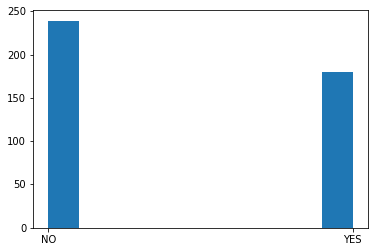

In [97]:
data.dtypes
data.describe()
data.MortgageDefault.describe()
import matplotlib.pyplot as plt
plt.hist(data.MortgageDefault)
plt.show()

###I rewrote the code below, borrowing from DataBricks. indexing and coding the categorical/string type columns. We input the one hot encoder and first iterate over the two string columns with the Stringindexer, creating category indexing. Then I use the OneHotEncoderEstimate, adding them to stages. I use the VectorAssembler to merge the assembler inputs into vector columns.

In [57]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorIndexer, IndexToString, OneHotEncoderEstimator
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
categoricalColumns = ['AppliedOnline','Residence']
stages=[]
for categoricalCol in categoricalColumns:
    # Category Indexing with StringIndexer
    stringIndexer = StringIndexer(inputCol=categoricalCol, outputCol=categoricalCol + "Index")
    encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    # Add stages.  These are not run here, but will run all at once later on.
    stages += [stringIndexer, encoder]

label_stringIdx = StringIndexer(inputCol = 'MortgageDefault', outputCol = 'label')
stages += [label_stringIdx]
numericCols = ['Income', 'YearCurrentAddress', 'YearsCurrentEmployer', 'NumberOfCards', 'CCDebt', 'Loans',"LoanAmount"]
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [99]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorIndexer, IndexToString
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier


SI1 = StringIndexer(inputCol='AppliedOnline', outputCol='AppliedOnlineEncoded')
SI2 = StringIndexer(inputCol='Residence',outputCol='ResidenceEncoded')
SI3 = StringIndexer(inputCol='Location',outputCol='LocationEncoded')
labelIndexer = StringIndexer(inputCol='MortgageDefault', outputCol='label')

OH1 = OneHotEncoder(inputCol="AppliedOnlineEncoded", outputCol="AppliedOnlineEncoded"+"classVec")
OH2 = OneHotEncoder(inputCol="ResidenceEncoded", outputCol="ResidenceEncoded"+"classVec")
OH3 = OneHotEncoder(inputCol="LocationEncoded", outputCol="LocationEncoded"+"classVec")

assembler = VectorAssembler(inputCols=["Income", "AppliedOnlineEncoded"+"classVec",\
                                       "ResidenceEncoded"+"classVec", "YearCurrentAddress",\
                                       "YearsCurrentEmployer", "NumberOfCards", "CCDebt", \
                                       "Loans", "LoanAmount", "SalePrice", "LocationEncoded"+"classVec"],\
                            outputCol="features")

In [42]:
data.head()

,ID,Income,AppliedOnline,Residence,YearCurrentAddress,YearsCurrentEmployer,NumberOfCards,CCDebt,Loans,LoanAmount,SalePrice,Location,MortgageDefault
0,100522.0,43982.0,YES,Owner Occupier,13.0,11.0,2.0,1055.0,0.0,9405.0,500000,110,NO
1,101756.0,59944.0,YES,Owner Occupier,20.0,11.0,2.0,3894.0,0.0,9880.0,750000,110,NO
2,101354.0,57718.0,YES,Owner Occupier,25.0,16.0,2.0,1555.0,1.0,6285.0,155000,130,YES
3,100512.0,45621.0,YES,Owner Occupier,1.0,19.0,1.0,1878.0,0.0,9260.0,195000,100,YES
4,100537.0,45081.0,NO,Owner Occupier,14.0,15.0,2.0,713.0,1.0,8430.0,140000,110,NO


###I initially tested a simple Logistic regression model just to make sure I got the pipeline set up correctly. I drop the ID column as it isnt a feature variable. I check the schema and the data to make sure the previous steps worked.

In [79]:
  
partialPipeline = Pipeline().setStages(stages)
pipelineModel = partialPipeline.fit(df)
preppedDataDF = pipelineModel.transform(df)
dataset = preppedDataDF.drop('ID')
display(dataset)
df.printSchema()
pd.DataFrame(preppedDataDF.take(5), columns=preppedDataDF.columns).transpose()


DataFrame[Income: double, AppliedOnline: string, Residence: string, YearCurrentAddress: double, YearsCurrentEmployer: double, NumberOfCards: double, CCDebt: double, Loans: double, LoanAmount: double, SalePrice: int, Location: int, MortgageDefault: string, AppliedOnlineIndex: double, AppliedOnlineclassVec: vector, ResidenceIndex: double, ResidenceclassVec: vector, label: double, features: vector]

root
 |-- ID: double (nullable = true)
 |-- Income: double (nullable = true)
 |-- AppliedOnline: string (nullable = true)
 |-- Residence: string (nullable = true)
 |-- YearCurrentAddress: double (nullable = true)
 |-- YearsCurrentEmployer: double (nullable = true)
 |-- NumberOfCards: double (nullable = true)
 |-- CCDebt: double (nullable = true)
 |-- Loans: double (nullable = true)
 |-- LoanAmount: double (nullable = true)
 |-- SalePrice: integer (nullable = true)
 |-- Location: integer (nullable = true)
 |-- MortgageDefault: string (nullable = true)



,0,1,2,3,4
ID,100522,101756,101354,100512,100537
Income,43982,59944,57718,45621,45081
AppliedOnline,YES,YES,YES,YES,NO
Residence,Owner Occupier,Owner Occupier,Owner Occupier,Owner Occupier,Owner Occupier
YearCurrentAddress,13,20,25,1,14
YearsCurrentEmployer,11,11,16,19,15
NumberOfCards,2,2,2,1,2
CCDebt,1055,3894,1555,1878,713
Loans,0,0,1,0,1
LoanAmount,9405,9880,6285,9260,8430


##I Split the data set in to a training and test set.

In [81]:
(trainingData, testData) = dataset.randomSplit([0.7, 0.3], seed=100)
print(trainingData.count())
print(testData.count())


288
131


#Initialize a RF and fit to the training data. Produce predictions with a transformation on the test data. 

In [82]:
rf = RandomForestClassifier(labelCol="label", featuresCol="features")
rfModel = rf.fit(trainingData)
predictions = rfModel.transform(testData)
selected = predictions.select("label", "LoanAmount", "NumberOfCards", 
                              "Income", "Loans")


DataFrame[label: double, LoanAmount: double, NumberOfCards: double, Income: double, Loans: double]

#We are ready to evaluate the models accuracy before moving on to hyperparamter tuning.

In [83]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator()
evaluator.evaluate(predictions)

0.675714285714286

#I build a parameter grid with maxdepth and number of trees

In [84]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

paramGrid = (ParamGridBuilder()
             .addGrid(rf.maxDepth, [2, 4, 6])
             .addGrid(rf.maxBins, [20, 60])
             .addGrid(rf.numTrees, [5, 20])
             .build())

#Initialize the CrossValidator to iterate over the parameter grid and get predictions.

In [85]:
cv = CrossValidator(estimator=rf, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)
cvModel = cv.fit(trainingData)
predictions = cvModel.transform(testData)
evaluator.evaluate(predictions)

0.5661904761904762

In [93]:
predictions.columns

['Income',
 'AppliedOnline',
 'Residence',
 'YearCurrentAddress',
 'YearsCurrentEmployer',
 'NumberOfCards',
 'CCDebt',
 'Loans',
 'LoanAmount',
 'SalePrice',
 'Location',
 'MortgageDefault',
 'AppliedOnlineIndex',
 'AppliedOnlineclassVec',
 'ResidenceIndex',
 'ResidenceclassVec',
 'label',
 'features',
 'rawPrediction',
 'probability',
 'prediction']

#We extract and evaluate the best model. 

In [94]:
bestModel = cvModel.bestModel
finalPredictions = bestModel.transform(dataset)
evaluator.evaluate(finalPredictions)

0.8167247791724781